In [ ]:
# ==========================================
# 1. Upload ZIP Dataset
# ==========================================
from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")

print("Dataset extracted successfully!")

# Detect if there's a top-level folder
root = "data"
items = os.listdir(root)
if len(items) == 1 and os.path.isdir(os.path.join(root, items[0])):
    root = os.path.join(root, items[0])
print("Using dataset root:", root)


Saving animal_dataset.zip to animal_dataset.zip
Dataset extracted successfully!
Using dataset root: data/animal_dataset


In [ ]:

# 2. Load & Preprocess Images (Grayscale 32x
import cv2
import numpy as np
import random

IMG_SIZE = 32
NUM_IMAGES = 300  # Number of images to select

features = []
labels = []
display_data = []

for cls in sorted(os.listdir(root)):
    cls_path = os.path.join(root, cls)
    if not os.path.isdir(cls_path):
        continue
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        features.append(gray.flatten() / 255.0)
        labels.append(cls)
        display_data.append((gray, cls, img_name))

# Shuffle and select 300 images
data = list(zip(features, labels, display_data))
random.shuffle(data)
data = data[:NUM_IMAGES]
features = np.array([d[0] for d in data])
labels = np.array([d[1] for d in data])
display_data = [d[2] for d in data]

print("Total images loaded:", len(features))


Total images loaded: 300


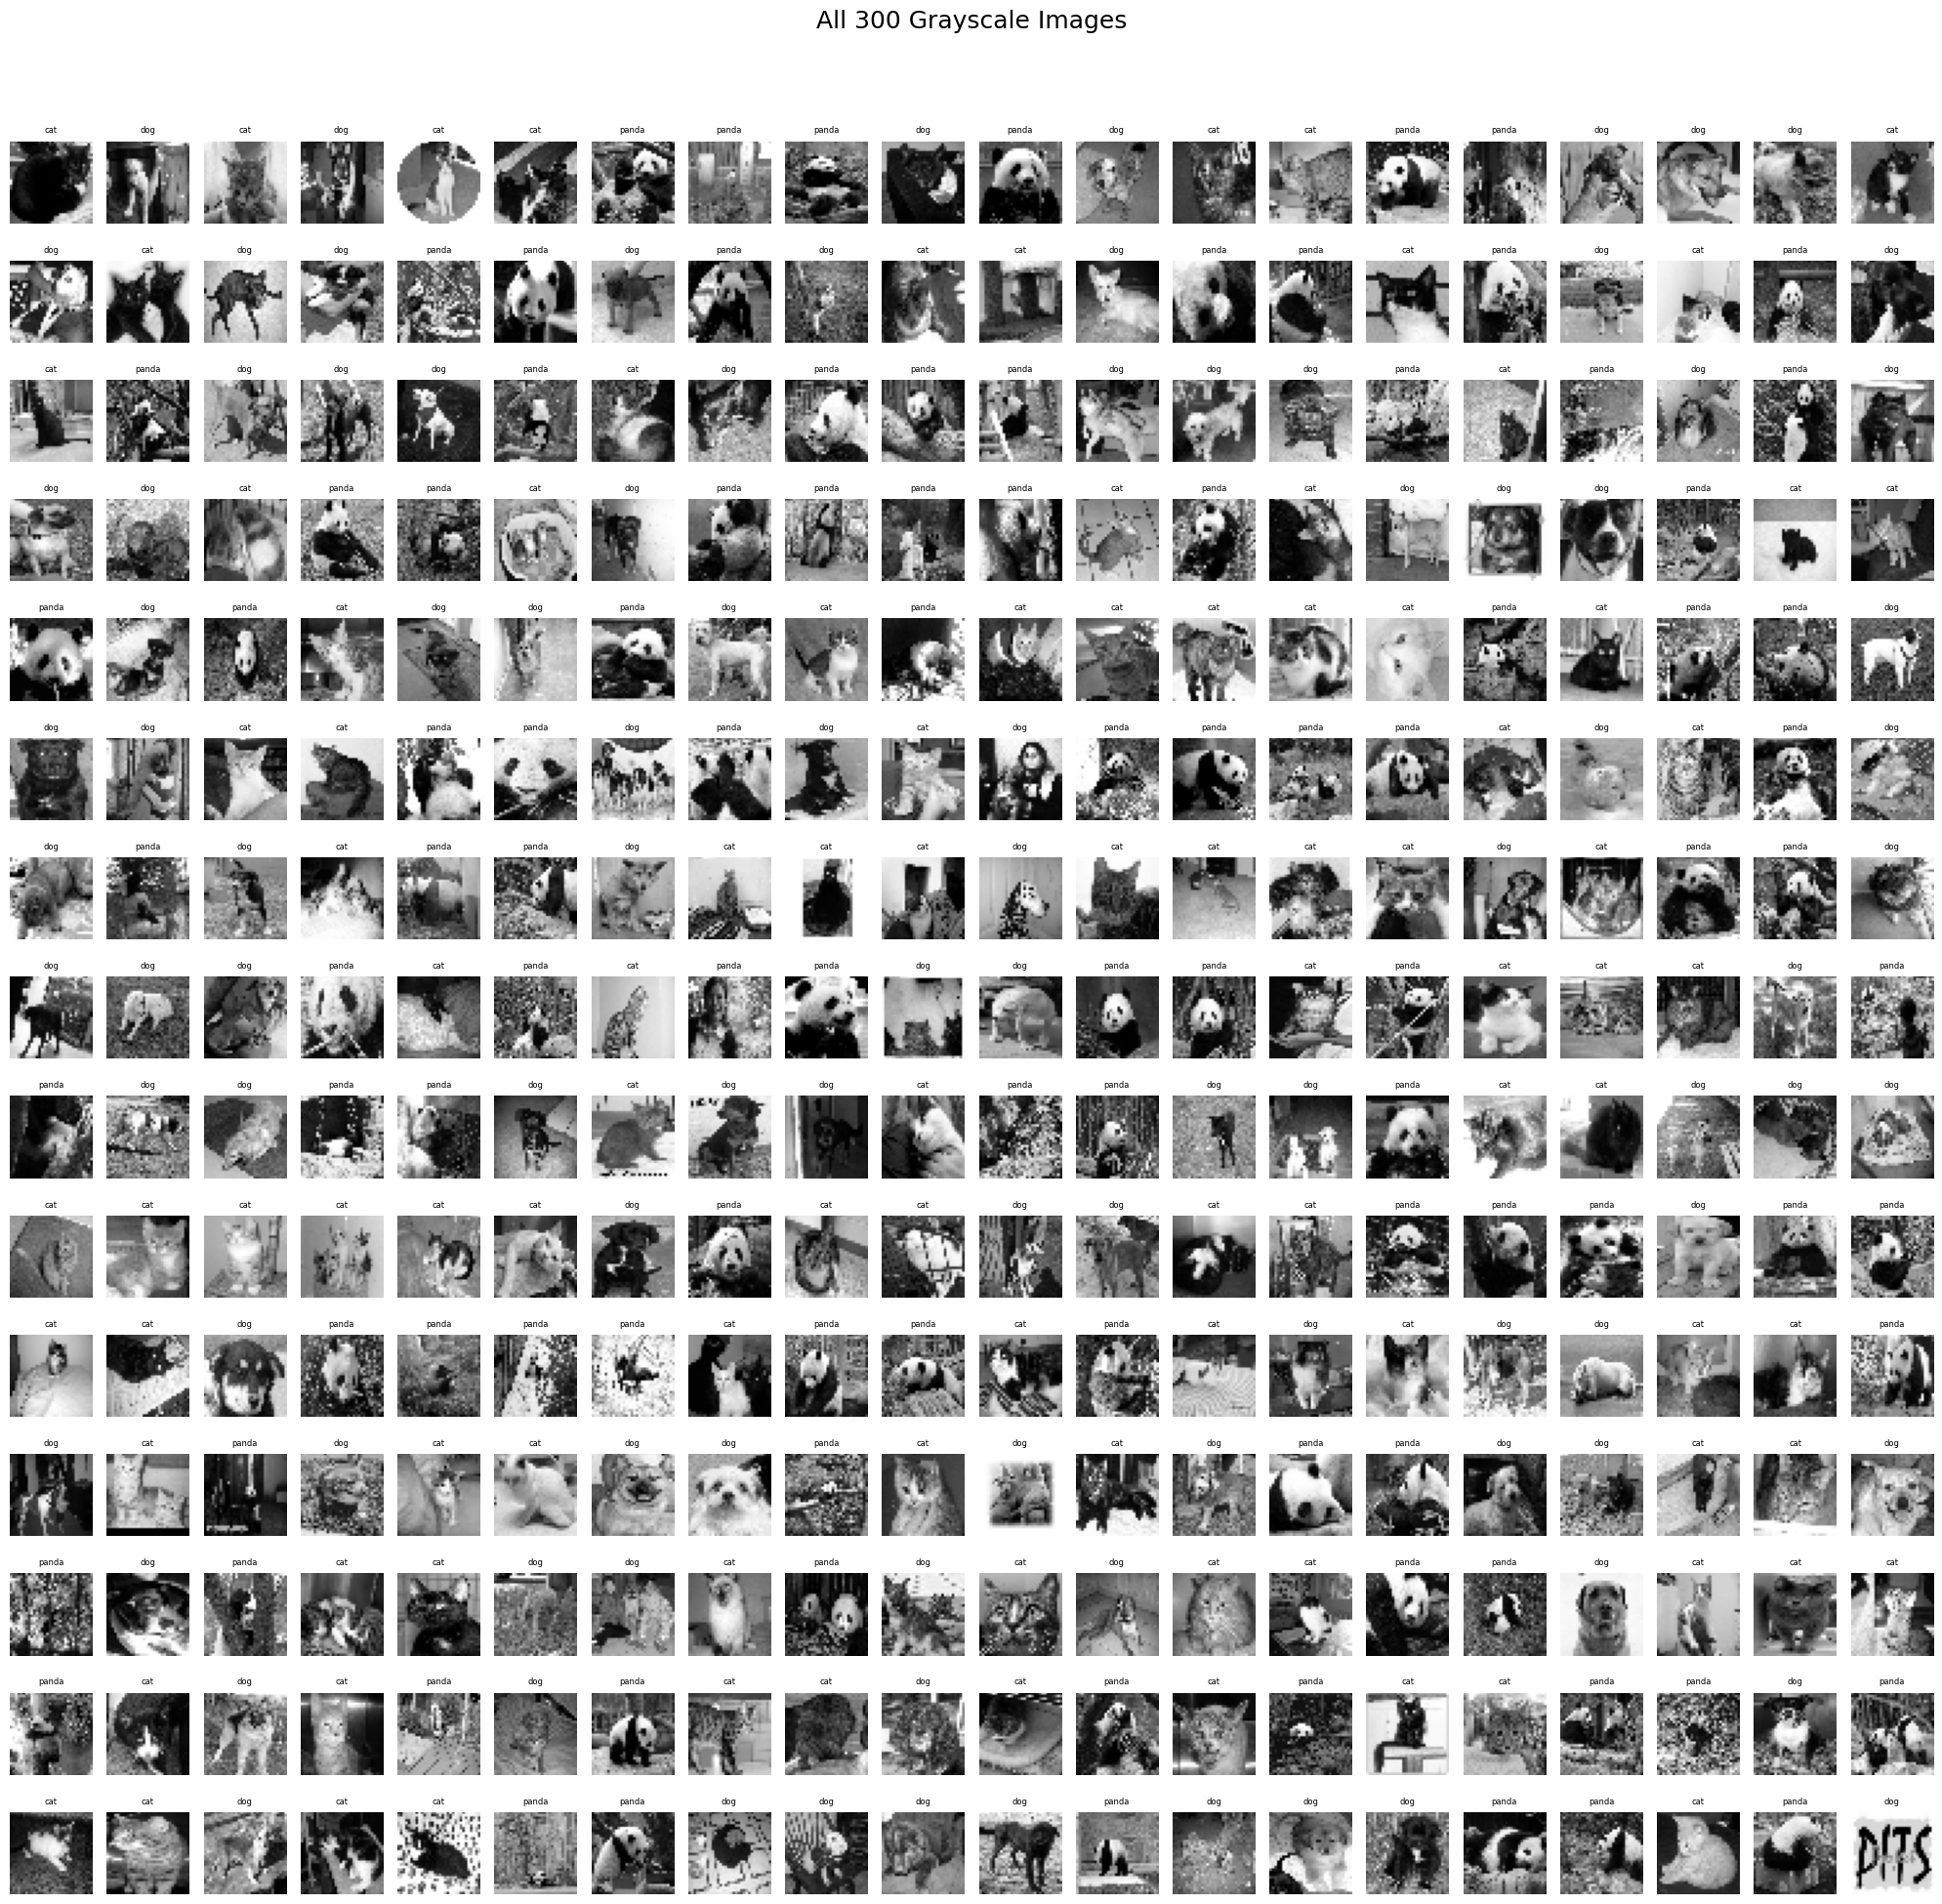

In [ ]:
# ==========================================
# 3. Display All 300 Images
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for i, (img, cls, name) in enumerate(display_data):
    plt.subplot(15, 20, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cls, fontsize=6)
    plt.axis('off')
plt.suptitle("All 300 Grayscale Images", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [ ]:
# ==========================================
# 4. kNN Distance Functions
# ==========================================
from collections import Counter

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def knn_predict(X_train, y_train, x_test, k=3, distance_type='L2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type=='L1':
            d = manhattan_distance(X_train[i], x_test)
        else:
            d = euclidean_distance(X_train[i], x_test)
        distances.append((d, y_train[i]))
    distances.sort(key=lambda x: x[0])
    k_labels = [label for _, label in distances[:k]]
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]


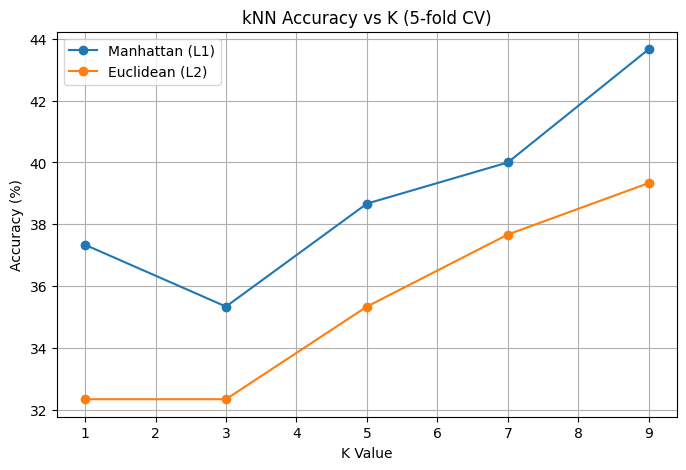

In [ ]:
# ==========================================
# 5. 5-Fold Cross-Validation
# ==========================================
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
K_values = [1, 3, 5, 7, 9]

def cross_validate(features, labels, distance_type='L2'):
    avg_accuracies = []
    for k in K_values:
        fold_acc = []
        for train_idx, val_idx in kf.split(features):
            X_train, X_val = features[train_idx], features[val_idx]
            y_train, y_val = labels[train_idx], labels[val_idx]
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                correct += (pred == y_val[i])
            fold_acc.append((correct/len(X_val))*100)
        avg_accuracies.append(np.mean(fold_acc))
    return avg_accuracies

# Run cross-validation
acc_L1 = cross_validate(features, labels, distance_type='L1')
acc_L2 = cross_validate(features, labels, distance_type='L2')

# Plot
plt.figure(figsize=(8,5))
plt.plot(K_values, acc_L1, 'o-', label="Manhattan (L1)")
plt.plot(K_values, acc_L2, 'o-', label="Euclidean (L2)")
plt.xlabel("K Value")
plt.ylabel("Accuracy (%)")
plt.title("kNN Accuracy vs K (5-fold CV)")
plt.grid(True)
plt.legend()
plt.show()


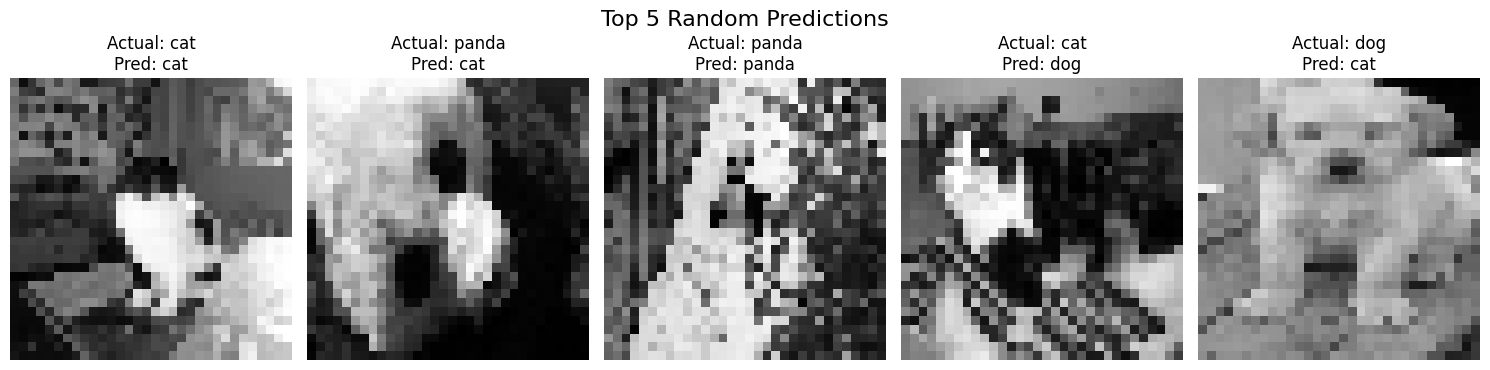

In [ ]:
# ==========================================
# 6. Show Top 5 Images with Actual & Predicted
# ==========================================
import random
plt.figure(figsize=(15,4))

# Pick 5 random images
indices = random.sample(range(len(features)), 5)

for i, idx in enumerate(indices):
    test_img = features[idx]
    test_label = labels[idx]
    pred_label = knn_predict(features, labels, test_img, k=3, distance_type='L2')

    plt.subplot(1, 5, i+1)
    plt.imshow(test_img.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Actual: {test_label}\nPred: {pred_label}")
    plt.axis('off')

plt.suptitle("Top 5 Random Predictions", fontsize=16)
plt.tight_layout()
plt.show()


Model Building and Evaluation

We used the k-nearest neighbors (k-NN) algorithm to classify gray-scale images. The model checks the labels of the k closest images using Manhattan (L1) and Euclidean (L2) distances. To evaluate performance, we applied 5-fold cross-validation, where the dataset is split into 5 parts and tested 5 times. This helps get a more reliable accuracy and reduces overfitting.

Results and Analysis

For each fold, we tested different values of K and recorded the accuracy for both L1 and L2 distances. We then calculated the average accuracy of each K across all folds. A graph was plotted showing how accuracy changes with different K values. This helps us understand which K gives the best performance for each distance metric.

Discussion

From the results, we compared Manhattan (L1) and Euclidean (L2) distances. L1 sometimes works better with image data because it handles pixel differences more smoothly, while L2 can be sensitive to large pixel changes. The best distance metric and K depend on how complex the dataset is. Improvements like normalization or using weighted k-NN could further increase accuracy.

Top 5 Predictions

Finally, we tested the model on new gray-scale images and showed the top 5 predictions. These results demonstrate how well the model can classify unseen images. The predictions give a quick idea of the model’s real-world performance and help check if the chosen K and distance metric are effective.